In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
sns.set_palette("Set2")

In [2]:
from dotenv import load_dotenv
from ephys_queries import db_setup_core, select_spike_times, select_discrete_data
from spiketimes.df.alignment import align_around_by
from spiketimes.df.binning import binned_spiketrain_bins_provided
from spiketimes.df.baseline import zscore_standardise_by
from spiketimes.df.statistics import diffmeans_test_by
from spiketimes.utils import p_adjust
from spiketimes.plots import add_event_vlines

In [3]:
from scipy.ndimage import gaussian_filter1d
from scipy.stats import zscore
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

In [4]:
data_dir = Path(".").absolute().parent / "data"
fig_dir = Path(".").absolute().parent / "figs"

### Import Data

In [5]:
group_names = ["acute_citalopram", 
            "acute_saline", 
            "shock", 
            "sham", 
            "acute_cit", 
            "acute_sal"]
dfb = (
    pd.read_csv(data_dir / "baseline.csv")
    .loc[lambda x: x["group_name"].isin(group_names)]
)

In [6]:
block_name = "base_shock"
fs = 30000
load_dotenv()
engine, metadata = db_setup_core()

df_spikes = (
    select_spike_times(
            engine, 
            metadata,
            group_names=group_names,
            block_name=block_name,
            )
    .assign(spiketimes=lambda x: x["spike_time_samples"].divide(fs))
)
df_events = (
    select_discrete_data(
            engine,
            metadata,
            group_names=group_names,
            block_name=block_name
    )
    .assign(event_s= lambda x: x["timepoint_sample"].divide(fs))
)

### Apply Exclusion Criteria

In [7]:
df_spikes = df_spikes.groupby("neuron_id").filter(lambda x: len(x) >= 1000)

### Construct PSTH

In [8]:
bins = np.round(np.arange(-0.5, 1.51, 0.01), 3)

psth = (
    align_around_by(
        df_data=df_spikes.merge(dfb[["neuron_id", "session_name"]]).dropna(),
        df_data_data_colname="spiketimes",
        df_data_group_colname="session_name",
        df_events=df_events,
        df_events_event_colname="event_s",
        df_events_group_colname="session_name",
        max_latency=1.5,
        t_before=0.5)
    .dropna()
    .pipe(lambda x: binned_spiketrain_bins_provided(x, 
                                bins=bins, 
                                spiketimes_col="aligned", 
                                spiketrain_col="neuron_id")
         )
)

c:\users\rory\repos\spiketimes\spiketimes\alignment.py:140: RuntimeWarning: invalid value encountered in greater_equal
  (negative_latencies >= (t_before * -1)),
c:\users\rory\repos\spiketimes\spiketimes\alignment.py:148: RuntimeWarning: invalid value encountered in greater
  latencies[latencies > max_latency] = np.nan


In [9]:
psth.head(3)

,neuron_id,bin,counts
0,1031,-0.50,23
1,1031,-0.49,19
2,1031,-0.48,13


### Permutation Tests

##### Define Conditions

In [10]:
psth = (
    psth
    .assign(cond=(
        lambda x: x["bin"].apply(lambda y: 0 if (y < 0.01) or (y > 0.3) else 1)
            ))
)

##### Define Responders

In [11]:
def response_dm(row, p_colname="p", diff_of_means_colname="diff_of_means"):
    if row[p_colname] >= 0.05:
        return "Non Responder"
    elif row[diff_of_means_colname] < 0:
        return "Inhibited"
    else:
        return "Stimulated"

df_effects = (
    diffmeans_test_by(df=psth, 
                        spiketrain_col="neuron_id", 
                        spikecount_col="counts", 
                        condition_col="cond")
    .rename(columns={"diff_of_means": "diff_of_means_baseshock",
                    "p": "p_baseshock"})
    .assign(p_baseshock = lambda x: p_adjust(x["p_baseshock"]),
            response_baseshock= lambda x: x.apply(response_dm, 
                                                  axis=1, 
                                                  p_colname="p_baseshock",
                                                  diff_of_means_colname="diff_of_means_baseshock"))
    .merge(dfb[["neuron_id", "cluster"]].drop_duplicates())
)

In [12]:
df_effects.head(3)

,neuron_id,diff_of_means_baseshock,p_baseshock,response_baseshock,cluster
0,1031,13.341176,0.0,Stimulated,slow_regular
1,1032,26.449020,0.0,Stimulated,slow_regular
2,1034,10.954902,0.0,Stimulated,slow_regular


In [13]:
df_effects.response_baseshock.value_counts()

Stimulated       90
Non Responder    64
Inhibited        30
Name: response_baseshock, dtype: int64

### Plot Heatmaps

##### Create Smoothed Data

In [14]:
psth_plot = (
    psth
    .pipe(lambda x: zscore_standardise_by(df=x, 
                      baseline_start_stop=np.array([-0.5, 0]),
                      time_col="bin",
                      data_col="counts", 
                      spiketrain_col="neuron_id"))
    .assign(z_smooth= lambda x: x.groupby("neuron_id")["zscore"]
                    .transform(lambda x: gaussian_filter1d(zscore(x), sigma=0.8)))
    .pivot(columns="bin", index="neuron_id", values="z_smooth")
    .reset_index()
    .merge(df_effects[["neuron_id", "response_baseshock"]])
)

c1 = psth_plot[psth_plot["response_baseshock"] == "Stimulated"].drop(["neuron_id", "response_baseshock"], axis=1).sort_values(by=0.1, ascending=False)
c2 = psth_plot[psth_plot["response_baseshock"] == "Inhibited"].drop(["neuron_id", "response_baseshock"], axis=1).sort_values(by=0.1, ascending=False)
c3 = psth_plot[psth_plot["response_baseshock"] == "Non Responder"].drop(["neuron_id", "response_baseshock"], axis=1).sort_values(by=0.1, ascending=False)

##### Stimulated Units

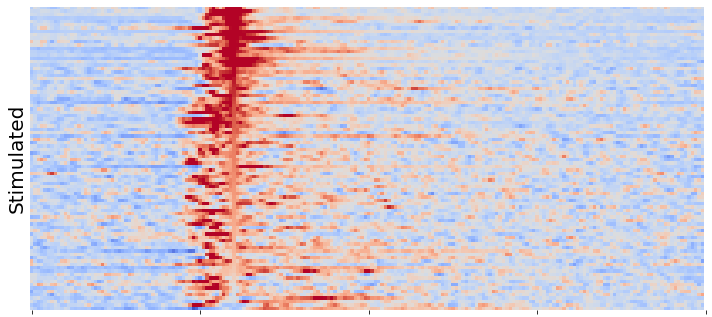

In [15]:
f, ax = plt.subplots(figsize=(10, 5))
ax.imshow(c1, cmap="coolwarm", vmin=-2.5, vmax=2.5)


ax.set_ylabel("Stimulated", fontsize=20)
ax.set_yticklabels([])
ax.set_yticks([])

ax.set(frame_on=False)
ticks = np.array([0, 50, 100, 150, 200])
ax.set_xticks(ticks)
ax.set_xticklabels([])


plt.tight_layout()
plt.savefig(fig_dir / "psth_stimulated_heat.png", dpi=300, transparent=True)

##### Inhibited Units

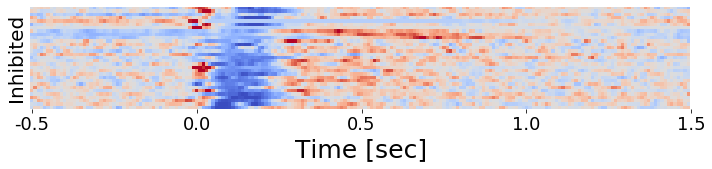

In [16]:
f, ax = plt.subplots(figsize=(10, 5))
ax.imshow(c2, cmap="coolwarm", vmin=-2.5, vmax=2.5)
ax.set_ylabel("Inhibited", fontsize=20)


ax.set_yticklabels([])
ax.set_yticks([])
ax.set(frame_on=False)
ax.set_xticks(ticks)
ax.set_xticklabels(np.round((ticks-50) * 0.01, 2), fontsize=18)
ax.set_xlabel("Time [sec]", fontsize=25)
plt.tight_layout()
plt.savefig(fig_dir / "psth_inhibited_heat.png", dpi=300, transparent=True)

##### Non Responders

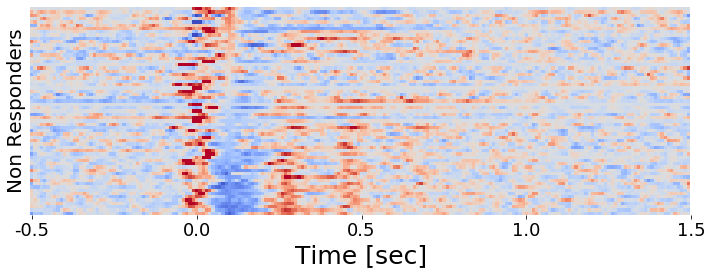

In [17]:
f, ax = plt.subplots(figsize=(10, 5))
ax.imshow(c3, cmap="coolwarm", vmin=-2.5, vmax=2.5)
ax.set_ylabel("Non Responders", fontsize=20)

ax.set_yticklabels([])
ax.set_yticks([])
ax.set(frame_on=False)
ax.set_xticks(ticks)
ax.set_xticklabels(np.round((ticks-50) * 0.01, 2), fontsize=18)
ax.set_xlabel("Time [sec]", fontsize=25)
plt.tight_layout()
plt.savefig(fig_dir / "psth_nonresponders_heat.png", dpi=300, transparent=True)

### Plot Example PSTH

In [15]:
df_aligned = align_around_by(
            df_data=df_spikes.merge(dfb[["neuron_id", "session_name"]]).dropna(),
            df_data_data_colname="spiketimes",
            df_data_group_colname="session_name",
            df_events=df_events,
            df_events_event_colname="event_s",
            df_events_group_colname="session_name",
            max_latency=1.5,
            t_before=0.5).dropna()

In [26]:
inhibited_neurons = df_effects[df_effects["response_baseshock"] == "Inhibited"]["neuron_id"].values
inhibited_neuron = np.random.choice(inhibited_neurons, 1)[0]

In [27]:
dfb[dfb["neuron_id"]==1813].cluster

262    slow_regular
Name: cluster, dtype: object

In [28]:
# inhibited_neuron = 1044

In [29]:
# inhibited_neuron = 1044
inhibited_neuron = 1813

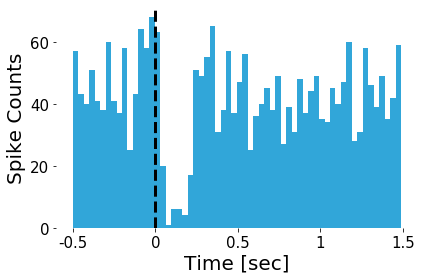

In [30]:
from spiketimes.df.binning import which_bin

f, ax = plt.subplots()

ax = which_bin(df_aligned[df_aligned["neuron_id"] == inhibited_neuron], bins[:-1], 
          spiketimes_col="aligned")["bin_values"].hist(bins=60, ax=ax, 
                                                       color="#31A6D9")

ax.grid(False)
ax.set(frame_on=False)

ax.set_yticks([0, 20, 40, 60])
ax.set_yticklabels([0, 20, 40, 60], fontsize=15)
ax.set_ylabel("Spike Counts", fontsize=20)

ax.set_xticks([-0.5, 0, 0.5, 1, 1.5])
ax.set_xticklabels([-0.5, 0, 0.5, 1, 1.5, 2], fontsize=15)

ax.set_xlabel("Time [sec]", fontsize=20)
ax = add_event_vlines(ax=ax, events=0, vline_kwargs={"linewidth": 3})

plt.tight_layout()
plt.savefig(fig_dir /"psth_inhibited_actual.png", dpi=300, transparent=True)

In [21]:
excited_neuron = df_effects[df_effects["response_baseshock"] == "Stimulated"]["neuron_id"].values
excited_neuron = np.random.choice(excited_neuron, 1)[0]

In [22]:
excited_neuron = 1983

In [23]:
dfb[dfb["neuron_id"]==1983].cluster

371    slow_regular
Name: cluster, dtype: object

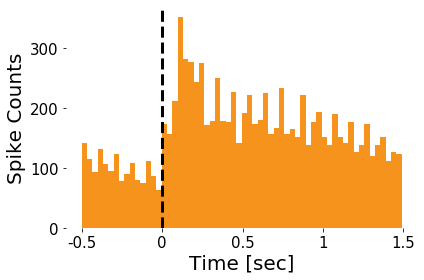

In [24]:
from spiketimes.df.binning import which_bin
f, ax = plt.subplots()

ax = which_bin(df_aligned[df_aligned["neuron_id"] == excited_neuron], bins[:-1], 
          spiketimes_col="aligned")["bin_values"].hist(bins=60, ax=ax, 
                                                       color="#F6931D")

ax.grid(False)
ax.set(frame_on=False)

ax.set_yticks([0, 100, 200, 300])
ax.set_yticklabels([0, 100, 200, 300], fontsize=15)
ax.set_ylabel("Spike Counts", fontsize=20)

ax.set_xticks([-0.5, 0, 0.5, 1, 1.5])
ax.set_xticklabels([-0.5, 0, 0.5, 1, 1.5, 2], fontsize=15)

ax.set_xlabel("Time [sec]", fontsize=20)

ax = add_event_vlines(ax=ax, events=0, vline_kwargs={"linewidth": 3})

plt.tight_layout()
plt.savefig(fig_dir / "psth_stimulated_actual.png", dpi=300, transparent=True)

## Subsection Analysis

### First 5 Minutes

In [26]:
df_effects.response_baseshock.value_counts()

Stimulated       90
Non Responder    63
Inhibited        31
Name: response_baseshock, dtype: int64

In [27]:
df_spikes_sub = df_spikes[df_spikes["spiketimes"] < 2100]

In [28]:
psth_sub = (
    align_around_by(
        df_data=df_spikes_sub.merge(dfb[["neuron_id", "session_name"]]).dropna(),
        df_data_data_colname="spiketimes",
        df_data_group_colname="session_name",
        df_events=df_events,
        df_events_event_colname="event_s",
        df_events_group_colname="session_name",
        max_latency=1.5,
        t_before=0.5)
    .dropna()
    .pipe(lambda x: binned_spiketrain_bins_provided(x, 
                                bins=bins, 
                                spiketimes_col="aligned", 
                                spiketrain_col="neuron_id")
         )
)

In [29]:
psth_sub = (
    psth_sub
    .assign(cond=(
        lambda x: x["bin"].apply(lambda y: 0 if (y < 0.01) or (y > 0.3) else 1)
            ))
)

In [30]:
df_effects.response_baseshock.value_counts()

Stimulated       90
Non Responder    63
Inhibited        31
Name: response_baseshock, dtype: int64

In [31]:
df_effects_ff = (
    diffmeans_test_by(df=psth_sub, 
                        spiketrain_col="neuron_id", 
                        spikecount_col="counts", 
                        condition_col="cond")
    .rename(columns={"diff_of_means": "diff_of_means_first_5",
                    "p": "p_first_5"})
    .assign(p_first_5 = lambda x: p_adjust(x["p_first_5"]),
            response_first_5= lambda x: x.apply(response_dm, 
                                                  axis=1, 
                                                  p_colname="p_first_5",
                                                  diff_of_means_colname="diff_of_means_first_5")
           )
#     .merge(df_effects)
)
df_effects = pd.merge(df_effects, df_effects_ff)

In [32]:
df_effects_ff.response_first_5.value_counts()

Stimulated       84
Non Responder    69
Inhibited        31
Name: response_first_5, dtype: int64

In [33]:
df_effects.response_baseshock.value_counts()

Stimulated       90
Non Responder    63
Inhibited        31
Name: response_baseshock, dtype: int64

### Second Shock Period

In [34]:
group_names_cs = ["acute_saline",  
            "acute_sal"]

block_name_cs = "chal_shock"

df_spikes_cs = (
    select_spike_times(
            engine, 
            metadata,
            group_names=group_names_cs,
            block_name=block_name_cs,
            )
    .assign(spiketimes=lambda x: x["spike_time_samples"].divide(fs))
)
df_events_cs = (
    select_discrete_data(
            engine,
            metadata,
            group_names=group_names_cs,
            block_name=block_name_cs
    )
    .assign(event_s= lambda x: x["timepoint_sample"].divide(fs))
)

In [35]:
df_spikes_cs.neuron_id.nunique()

77

In [36]:
df_spikes_cs = df_spikes_cs.groupby("neuron_id").filter(lambda x: len(x) >= 1000)

In [37]:
psth_cs = (
    align_around_by(
        df_data=df_spikes_cs.merge(dfb[["neuron_id", "session_name"]]).dropna(),
        df_data_data_colname="spiketimes",
        df_data_group_colname="session_name",
        df_events=df_events_cs,
        df_events_event_colname="event_s",
        df_events_group_colname="session_name",
        max_latency=1.5,
        t_before=0.5)
    .dropna()
    .pipe(lambda x: binned_spiketrain_bins_provided(x, 
                                bins=bins, 
                                spiketimes_col="aligned", 
                                spiketrain_col="neuron_id")
         )
)

In [38]:
psth_cs = (
    psth_cs
    .assign(cond=(
        lambda x: x["bin"].apply(lambda y: 0 if (y < 0.01) or (y > 0.3) else 1)
            ))
)

In [39]:
df_effects_cs = (
    diffmeans_test_by(df=psth_cs, 
                        spiketrain_col="neuron_id", 
                        spikecount_col="counts", 
                        condition_col="cond")
    .rename(columns={"diff_of_means": "diff_of_means_chalshock",
                    "p": "p_chalshock"})
    .assign(p_chalshock = lambda x: p_adjust(x["p_chalshock"]),
            response_chalshock= lambda x: x.apply(response_dm, 
                                                  axis=1, 
                                                  p_colname="p_chalshock",
                                                  diff_of_means_colname="diff_of_means_chalshock"))
)
df_effects = pd.merge(df_effects_cs, df_effects, how="outer").merge(dfb[["neuron_id", "cluster", "group_name"]])

In [40]:
df_effects.to_csv(data_dir / "psth_responses.csv", index=False)